# Coursework 2: Generative Models

## Instructions

Please submit on CATe two zip files:

*CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells below.**
2. Your trained VAE model as *VAE_model.pth*

*GAN.zip* containing your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*

Please avoid using markdown headings (# ## etc.) as these will affect the ToC. Instead use html headings if you want emphasis.

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

TAs will run a testing cell (at the end of this notebook), so you are required to copy your transform and denorm functions to a cell near the bottom of the document (it is demarkated).

<font color="blue">**The deadline for submission is 19:00, Thursday 19th February, 2021** </font>

## Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch and import some utilities by running the following cell:

In [1]:
!pip install -q torch torchvision
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
# %load_ext google.colab.data_table

In [9]:
from google.colab import drive
drive.mount('/content/drive') # Outputs will be saved in your google drive

Mounted at /content/drive


## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points. 

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. Experiment with Feedforward and Convolutional Layers to see which gives better results.

b. Design an appropriate loss function and train the model.


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# CHANGE BACK    
if not os.path.exists('/content/drive/MyDrive/icl_dl_cw2/CW_VAE/'):
    os.makedirs('/content/drive/MyDrive/icl_dl_cw2/CW_VAE/')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
###Hyper-parameter selection


In [4]:
# Necessary Hyperparameters 
num_epochs = 100
learning_rate = 0.001
batch_size = 64
latent_dim = 12 # Choose a value for the size of the latent space

# Additional Hyperparameters 
capacity = 64


# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [5]:
# CHANGE BACK
train_dat = datasets.MNIST("data/", train=True, download=True, transform=transform)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

# train_dat = datasets.MNIST(
    # "/vol/bitbucket/yc7620/90_data", train=True, download=True, transform=transform
# )
# test_dat = datasets.MNIST("/vol/bitbucket/yc7620/90_data", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
# CHANGE BACK
save_image(fixed_input, '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/image_original.png')
# save_image(fixed_input, 'image_original.png')

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [7]:
# *CODE FOR PART 1.1a IN THIS CELL*

class ConvVAE(nn.Module):
    def __init__(self, latent_dim, capacity):

        super(ConvVAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # encoder components
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=capacity, kernel_size=4, stride=2, padding=1) # out: capacity x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=capacity, out_channels=capacity*2, kernel_size=4, stride=2, padding=1) # out: capacity x 7 x 7
        self.fc_mu = nn.Linear(in_features=capacity*2*7*7, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=capacity*2*7*7, out_features=latent_dim)
        
        # decoder components
        self.fc = nn.Linear(in_features=latent_dim, out_features=capacity*2*7*7)
        self.dconv2 = nn.ConvTranspose2d(in_channels=capacity*2, out_channels=capacity, kernel_size=4, stride=2, padding=1)
        self.dconv1 = nn.ConvTranspose2d(in_channels=capacity, out_channels=1, kernel_size=4, stride=2, padding=1)
        
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        # send image into the latent-dimensional space
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        # to apply reparametrization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        return mu + eps*std   

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # map from latent space 
        x = self.fc(z)
        x = x.view(x.size(0), capacity*2, 7, 7) # batch of multi-channel feature maps
        x = F.relu(self.dconv2(x))
        x = torch.sigmoid(self.dconv1(x)) 
        return x

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        latent_mu, latent_logvar = self.encode(x)
        latent = self.reparametrize(latent_mu, latent_logvar)
        x_recon = self.decode(latent)
        return x_recon, latent_mu, latent_logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


model = ConvVAE(latent_dim=latent_dim,capacity=capacity).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 496537
ConvVAE(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=6272, out_features=12, bias=True)
  (fc_logvar): Linear(in_features=6272, out_features=12, bias=True)
  (fc): Linear(in_features=12, out_features=6272, bias=True)
  (dconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


--- 

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [8]:
# CONVVAE

# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        BCEL = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        # regularizing term
        KLD = - beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCEL + KLD
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


def log_likelikehood_loss(recon_x, x, mu, logvar):
        ''' returns binary cross entropy'''
        
        BCEL = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        # regularizing term
        return BCEL
    

def KLD_loss(recon_x, x, mu, logvar):
        ''' returns KLD'''
        KLD = - torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return KLD    



# lists to keep average losses at epoch iteration
train_loss_epoch = [] 
test_loss_epoch = []

train_log_likelihood_epoch = []
test_log_likelihood_epoch = []

train_KLD_epoch = []
test_KLD_epoch = []


for epoch in range(num_epochs): 
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################        
        # prep to train
        model.train()
        # initiate train loss for each epoch
        train_loss = 0 
        train_log_likelihood = 0
        train_KLD = 0
        for it, (data, _) in enumerate(loader_train):
            data = data.to(device)
            # clear optimizer
            optimizer.zero_grad()
            # encode-decode
            recon_data, mu, logvar = model(data)
            # compute loss and do backprop
            loss = loss_function_VAE(recon_data.view(-1,784), data, mu, logvar, 0.5)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            # compute individual loss terms
            train_log_likelihood += log_likelikehood_loss(recon_data.view(-1,784), data, mu, logvar).item()
            train_KLD += KLD_loss(recon_data, data, mu, logvar).item()
            
            # print
            if it % 1000 == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (epoch, it, loss.item()))
        train_loss_epoch.append(train_loss/len(loader_train))
        train_log_likelihood_epoch.append(train_log_likelihood/len(loader_train))
        train_KLD_epoch.append(train_KLD/len(loader_train))
        
        
        #prep to test
        model.eval()
        # set test loss to zero at the top
        test_loss = 0 
        test_log_likelihood = 0
        test_KLD = 0
        with torch.no_grad(): # avoid touching grad=True computations
            for it, (data, _) in enumerate(loader_test):
                data = data.to(device)
                # encode-decode
                recon_data, mu, logvar = model(data)
                # compute loss
                test_loss += loss_function_VAE(recon_data.view(-1,784), data, mu, logvar, 0.5).item()
                # compute individual loss terms
                test_log_likelihood += log_likelikehood_loss(recon_data.view(-1,784), data, mu, logvar).item()
                test_KLD += KLD_loss(recon_data.view(-1,784), data, mu, logvar).item()
                
            test_loss_epoch.append(test_loss/len(loader_test))
            test_log_likelihood_epoch.append(test_log_likelihood/len(loader_train))
            test_KLD_epoch.append(test_KLD/len(loader_train))

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        # save the model
        if epoch == num_epochs - 1:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/VAE_model.pth')  


Epoch: 0, Iteration 0, loss = 32144.8535
Epoch: 1, Iteration 0, loss = 6408.9932
Epoch: 2, Iteration 0, loss = 6100.6440
Epoch: 3, Iteration 0, loss = 6255.0894
Epoch: 4, Iteration 0, loss = 5547.3711
Epoch: 5, Iteration 0, loss = 6198.0713
Epoch: 6, Iteration 0, loss = 5860.4614
Epoch: 7, Iteration 0, loss = 5631.8594
Epoch: 8, Iteration 0, loss = 5461.8452
Epoch: 9, Iteration 0, loss = 5643.4512
Epoch: 10, Iteration 0, loss = 5702.8232
Epoch: 11, Iteration 0, loss = 5757.9478
Epoch: 12, Iteration 0, loss = 5759.9980
Epoch: 13, Iteration 0, loss = 5589.3071
Epoch: 14, Iteration 0, loss = 5914.2607
Epoch: 15, Iteration 0, loss = 5939.8779
Epoch: 16, Iteration 0, loss = 5877.8096
Epoch: 17, Iteration 0, loss = 5238.5474
Epoch: 18, Iteration 0, loss = 5555.4736
Epoch: 19, Iteration 0, loss = 5623.3794
Epoch: 20, Iteration 0, loss = 5469.1514
Epoch: 21, Iteration 0, loss = 5380.4072
Epoch: 22, Iteration 0, loss = 5527.5273
Epoch: 23, Iteration 0, loss = 5749.3730
Epoch: 24, Iteration 0, l

### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


The choice of loss has two competing terms: $$ L = BCE + \beta * KL \ . $$ The binary cross-entropy $BCE$ term is in place because we check the performance of the encoder-decoder using the classification-type metric:  is the reproduced image close to the original one or not? Here we try to minimize the the loss between the original and the reproduced image.

The $KL$ term is given by: $$ D_{KL} (q_{\theta}(z|x^{(i)}) || p_\theta(z)) \sim -\sum \left(  1 + \log \sigma_i^2 - \mu_i^2 - \sigma^2_i \right) \ . $$ It works as a regularizing term preventing $BCE$ from pushing $\sigma_i$ to near zero norm learning very narrow distributions which would reproduce elements of the correct class but without enough detail to fully match the original image. $KL$ also pushes the means $\mu_i$ of each class apart which helps the decoder draw from the correct class.

The $KL$ term $$D_{KL}(q_{\theta}(z|x^{(i)}) || p_\theta(z))$$ pushes the learned latent distribution $q_{\theta}(z|x^{(i)})$ to that of the prior $p(z)$. Together the total loss $L$ helps produce smooth overlaps and no gaps between the classes so that we can smoothly move from one class to another.



In [ ]:
# Any code for your explanation here

**YOUR ANSWER**

<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

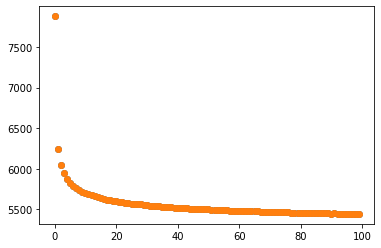

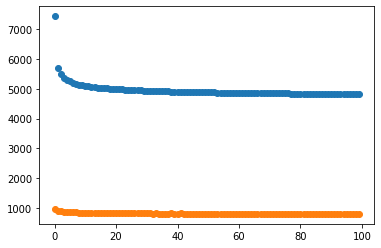

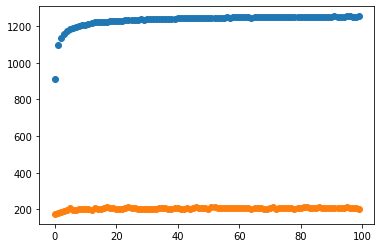

In [9]:
# *CODE FOR PART 1.2a IN THIS CELL*
import matplotlib.pyplot as plt

plt.scatter(range(len(train_loss_epoch)), train_loss_epoch)
plt.scatter(range(len(test_loss_epoch)), train_loss_epoch)
plt.show()

plt.scatter(range(len(train_log_likelihood_epoch)), train_log_likelihood_epoch)
plt.scatter(range(len(test_log_likelihood_epoch)), test_log_likelihood_epoch)
plt.show()

plt.scatter(range(len(train_KLD_epoch)), train_KLD_epoch)
plt.scatter(range(len(test_KLD_epoch)), test_KLD_epoch)
plt.show()

## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

Input images
--------------------------------------------------
torch.Size([32, 1, 28, 28])
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------
z size torch.Size([256, 12])


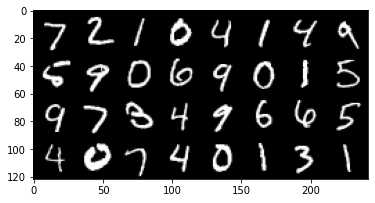

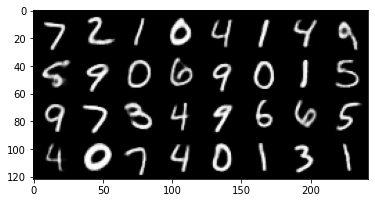

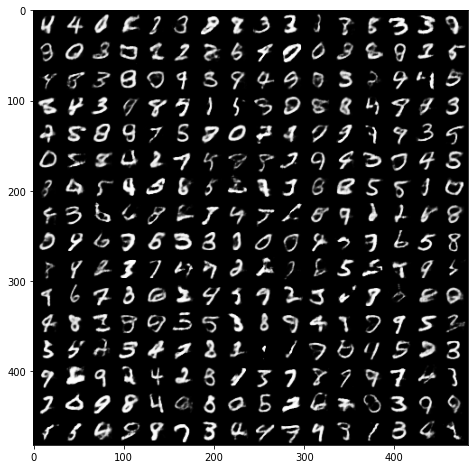

In [10]:
# CONVAE

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
print(fixed_input.size())
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
#     #######################################################################
#     #                       ** START OF YOUR CODE **
#     #######################################################################
    data = sample_inputs.to(device)
    recon_batch = model(data)[0]
    recon_batch = recon_batch.view(64,1,28,28)[0:32,:,:,:]


    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
print('z size', z.size())
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    samples = samples.view(256,1,28,28)

    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions: 
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? 
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [12]:
# *CODE FOR PART 1.3a IN THIS CELL
from sklearn.manifold import TSNE

test_data_for_array = [x[0].squeeze().view(-1,28*28).numpy() for x in (iter(loader_test))]
test_data_for_array = np.concatenate(test_data_for_array)

z_embedded = TSNE(n_components=2).fit_transform(test_data_for_array)

In [39]:
# Interactive Visualization - Code Provided
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
""" Inputs to the function are
        z_embedded - X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)


Output hidden; open in https://colab.research.google.com to view.

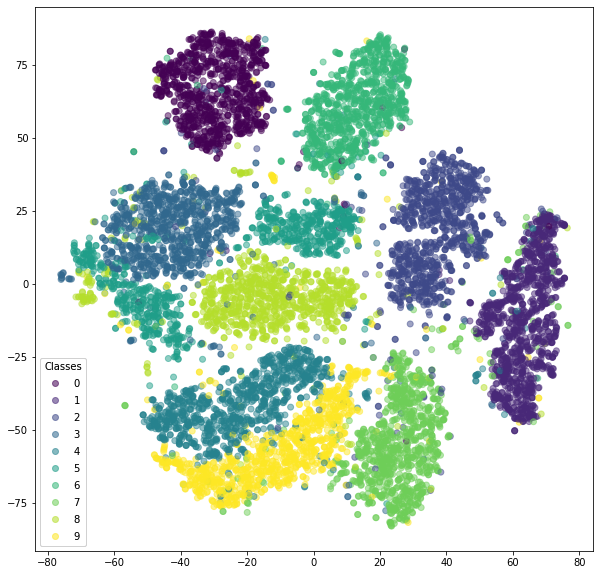

In [53]:
# Custom Visualizations

# get labels of points in test set
labels_test = list(np.concatenate([x[1].numpy() for x in iter(loader_test)]))


fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(z_embedded[:,0], z_embedded[:,1], c=labels_test, alpha=.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

### Discussion
What do you observe? Discuss the structure of the visualized representations. 
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

**YOUR ANSWER**

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?


In [73]:
# CODE FOR PART 1.3b IN THIS CELL

# grab two samples
a,b = next(iter(loader_test))

zero_tensor = a[3] # this data point has label 0
one_tensor = a[2]  # this data point has label 1

# embed zero
latent_mu_zero, latent_logvar_zero = model.encode(zero_tensor.unsqueeze(0).to(device))
zero_z = model.reparametrize(latent_mu_zero, latent_logvar_zero) 

# embed one
latent_mu_one, latent_logvar_one = model.encode(one_tensor.unsqueeze(0).to(device))
one_z = model.reparametrize(latent_mu_one, latent_logvar_one) 

In [79]:
# interpolate
def zero_one_interpolate(t=0.):
    ''' 
    Args: 
        t[float] interpolating factor between 0. and 1.
    Returns:
        z[tensor] embedded linear combination between zero_z 
        and one_z
        '''
    # linear interpolation
    T = t*zero_z + (1.-t)*one_z
    # decode
    T_decoded = model.decode(T).view(1,28,28).unsqueeze(0).cpu().detach()
    
    return T_decoded

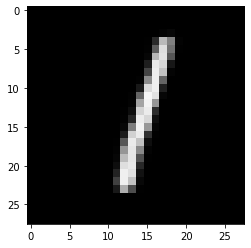

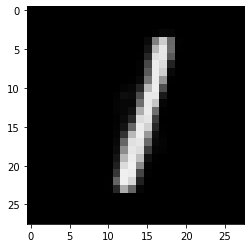

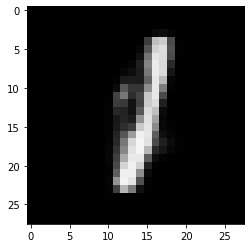

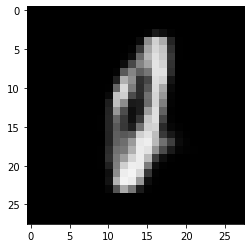

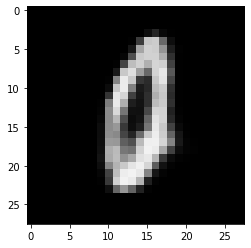

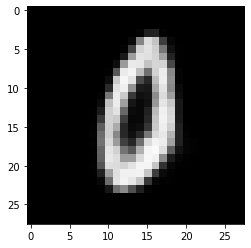

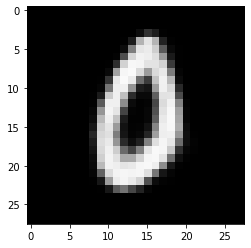

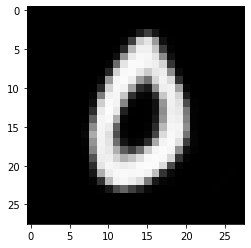

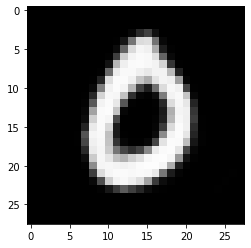

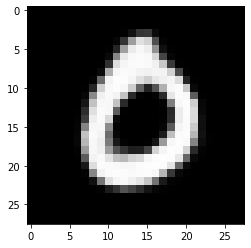

In [80]:
for t in np.linspace(0,1,10):
    
    # get interpolated decoded tensor
    recon_t = zero_one_interpolate(t)
    samples_t = make_grid(denorm(recon_t), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (4,4))
    show(samples_t)
    

### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

## Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. 

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# CHANGE BACK
# if not os.path.exists('/content/drive/MyDrive/icl_dl_cw2/CW_GAN'):
#     os.makedirs('/content/drive/MyDrive/icl_dl_cw2/CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [ ]:
batch_size =  64 # change that

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),),                        
])

# data_dir = './datasets'
data_dir = '/vol/bitbucket/yc7620/90_data/'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set: 

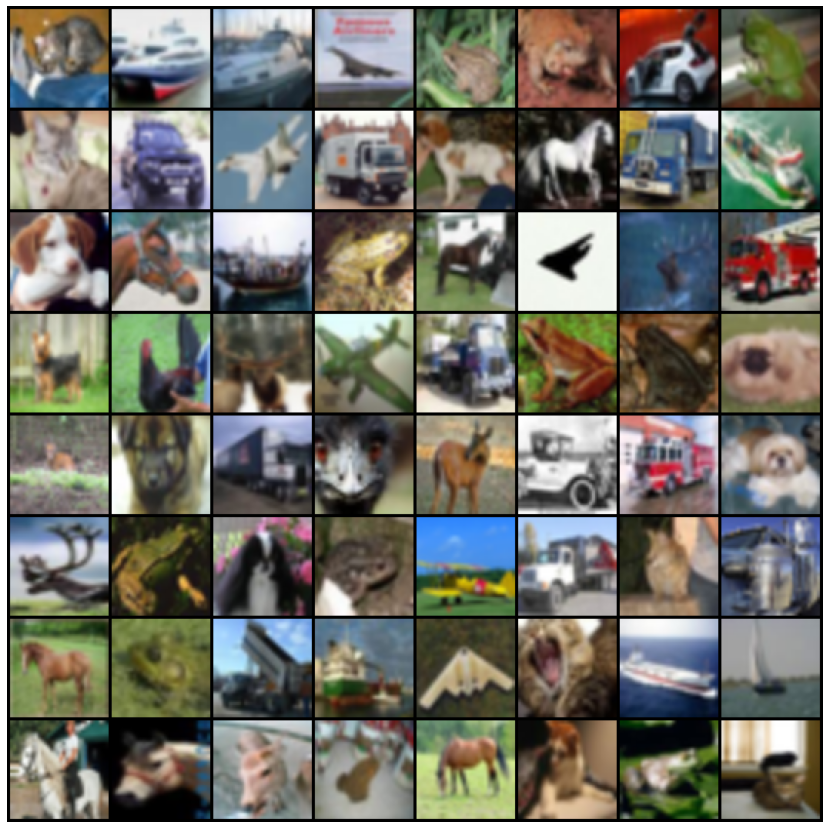

In [ ]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [ ]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 20
learning_rate = 0.0002
# the referenced paper has 100-dim'l latent space
latent_vector_size = 100 

# Other hyperparams
mid_size = 64
gen_out_chan = 3
disc_mid_size = 64

In [ ]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.layers = nn.Sequential(
        
            
            nn.ConvTranspose2d( latent_vector_size, mid_size * 8, 4, 1, 0, bias=False), # output shape (mid_size*8) x 4 x 4
            nn.BatchNorm2d(mid_size * 8),
            nn.ReLU(True),
          
            nn.ConvTranspose2d(mid_size * 8, mid_size * 4, 4, 2, 1, bias=False), # output size (mid_size*4) x 8 x 8
            nn.BatchNorm2d(mid_size * 4),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( mid_size * 4, mid_size * 2, 4, 2, 1, bias=False), # output size (mid_size*2) x 16 x 16
            nn.BatchNorm2d(mid_size * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( mid_size * 2, mid_size, 4, 2, 1, bias=False), # output size (mid_size) x 32 x 32
            nn.BatchNorm2d(mid_size),
            nn.ReLU(True),

            nn.ConvTranspose2d( mid_size, gen_out_chan, 4, 2, 1, bias=False),
            nn.Tanh()
          
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


    def forward(self, z, label=None):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.layers(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.layers = nn.Sequential(
        
            # input size (gen_out_chan) x 64 x 64
            nn.Conv2d(gen_out_chan, disc_mid_size, 4, 2, 1, bias=False), # output size (disc_mid_size) x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(disc_mid_size, disc_mid_size * 2, 4, 2, 1, bias=False), # output size (disc_mid_size*2) x 16 x 16
            nn.BatchNorm2d(disc_mid_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(disc_mid_size * 2, disc_mid_size * 4, 4, 2, 1, bias=False), # output size. (disc_mid_size*4) x 8 x 8
            nn.BatchNorm2d(disc_mid_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(disc_mid_size * 4, disc_mid_size * 8, 4, 2, 1, bias=False), # output size. (disc_mid_size*8) x 4 x 4
            nn.BatchNorm2d(disc_mid_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(disc_mid_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def forward(self, x, label=None):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.layers(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3576704
Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [ ]:
def loss_function(out, label):
    loss = F.binary_cross_entropy(out,label)
    return loss

<h3>Choose and initialize optimizers</h3>

In [ ]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))


<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [ ]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

#### Training Loop

In [ ]:
a = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
def smooth_real_label(y):
	return y - 0.3 + (torch.rand(y.shape).to(device) * 0.5)
smooth_real_label(a).max()

tensor(1.1972, device='cuda:0')

In [ ]:
# https://github.com/soumith/ganhacks
# https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/

# label smoothing
# add noise to labels

def smooth_real_label(label):
    ''' helper function to smooth labels'''
    return label - 0.3 + (torch.rand(label.shape).to(device) * 0.5)

from numpy.random import choice

# randomly flip some labels
def noisy_labels(label, p:float):
    ''' helper function to randomly flip p-fraction of true labels'''
    n_select = int(p * label.size(0))
    flip_ix = choice(list(range(label.size(0))), size=n_select)
    # flip
    label[flip_ix] = 1 - label[flip_ix]
    return label

train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
       
        model_D.zero_grad()
        # train with real
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device) 
        label = smooth_real_label(label)
        label = noisy_labels(label, p=0.05)
        # D on real data
        D_real_output = model_D(real_data).view(-1)
        # compute D real error
        loss_D_real = loss_function(D_real_output, label)
        # backward pass
        loss_D_real.backward()
        D_x = D_real_output.mean().item()
        
        # train with fake
        
        # latent-like tensor
        latent_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        # create fake images 
        fake_data = model_G(latent_noise)
        label.fill_(fake_label)
        # D on fake data
        D_fake_output = model_D(fake_data.detach()).view(-1)
        # compute D fake data
        loss_D_fake = loss_function(D_fake_output, label)
        # backward pass
        loss_D_fake.backward()
        D_G_z1 = D_real_output.mean().item()
        # total gradient
        errD = loss_D_real + loss_D_fake
        train_loss_D += errD.item()
        # update model_D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        
        label.fill_(real_label)
        # create fake images
        D_fake_output = model_D(fake_data).view(-1)
#         print(D_.size())
#         print(label.size())
        loss_G = loss_function(D_fake_output, label)
        train_loss_G += loss_G.item()
        # backward pass
        loss_G.backward()
        D_G_z2 = D_fake_output.mean().item()
        # update model_G
        optimizerG.step()
        
        if i % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader_train),
                     errD.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
#         CHANGE BACK
#         save_image(denorm(real_data.cpu()).float(), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/real_samples.png')
        save_image(denorm(real_data.cpu()).float(), '/content/sample_data//real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
#         CHANGE BACK
#         save_image(denorm(fake.cpu()).float(), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/fake_samples_epoch_%03d.png' % epoch)
        save_image(denorm(fake.cpu()).float(), '/content/sample_data/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G  / len(loader_train))
   
    
# save  models 
# if your discriminator/generator are conditional you'll want to change the inputs here
# CHANGE BACK

# torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/GAN_G_model.pth')
# torch.jit.save(torch.jit.trace(model_D, (fake)), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/GAN_D_model.pth')
# torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), '/vol/bitbucket/yc7620/90_data//GAN_G_model.pth')
# torch.jit.save(torch.jit.trace(model_D, (fake)), '/vol/bitbucket/yc7620/90_data/GAN_D_model.pth')



[0/20][0/782] Loss_D: 1.7303 Loss_G: 3.5801 D(x): 0.2791 D(G(z)): 0.2791 / 0.0332
[0/20][200/782] Loss_D: 0.5693 Loss_G: 3.9452 D(x): 0.8622 D(G(z)): 0.8622 / 0.0248
[0/20][400/782] Loss_D: 0.6535 Loss_G: 3.9020 D(x): 0.8290 D(G(z)): 0.8290 / 0.0314
[0/20][600/782] Loss_D: 0.8207 Loss_G: 4.2759 D(x): 0.8237 D(G(z)): 0.8237 / 0.0241
[1/20][0/782] Loss_D: 0.9422 Loss_G: 3.2736 D(x): 0.5631 D(G(z)): 0.5631 / 0.0701
[1/20][200/782] Loss_D: 0.8628 Loss_G: 4.7820 D(x): 0.8283 D(G(z)): 0.8283 / 0.0153
[1/20][400/782] Loss_D: 0.4834 Loss_G: 3.6962 D(x): 0.7797 D(G(z)): 0.7797 / 0.0341
[1/20][600/782] Loss_D: 0.8536 Loss_G: 3.0181 D(x): 0.6314 D(G(z)): 0.6314 / 0.0769
[2/20][0/782] Loss_D: 0.7700 Loss_G: 3.0462 D(x): 0.5414 D(G(z)): 0.5414 / 0.0850
[2/20][200/782] Loss_D: 0.6505 Loss_G: 3.8751 D(x): 0.8432 D(G(z)): 0.8432 / 0.0304
[2/20][400/782] Loss_D: 0.7398 Loss_G: 3.6782 D(x): 0.7731 D(G(z)): 0.7731 / 0.0353
[2/20][600/782] Loss_D: 0.7590 Loss_G: 3.5837 D(x): 0.8903 D(G(z)): 0.8903 / 0.035

## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://drive.google.com/uc?id=1wQ2f10-A1Vs7k0LMfBPPyYTsPlkBF9QE" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1wlDhX4hROET4s8Ndxn8nhj_0RLM2rnuG" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1w9VrgfJLCRaTPhwoFVYdYhtCeaQmFHGb" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

### Generator samples

In [ ]:
fixed_input.shape

torch.Size([64, 3, 64, 64])

In [ ]:
generated.shape

torch.Size([3, 662, 662])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


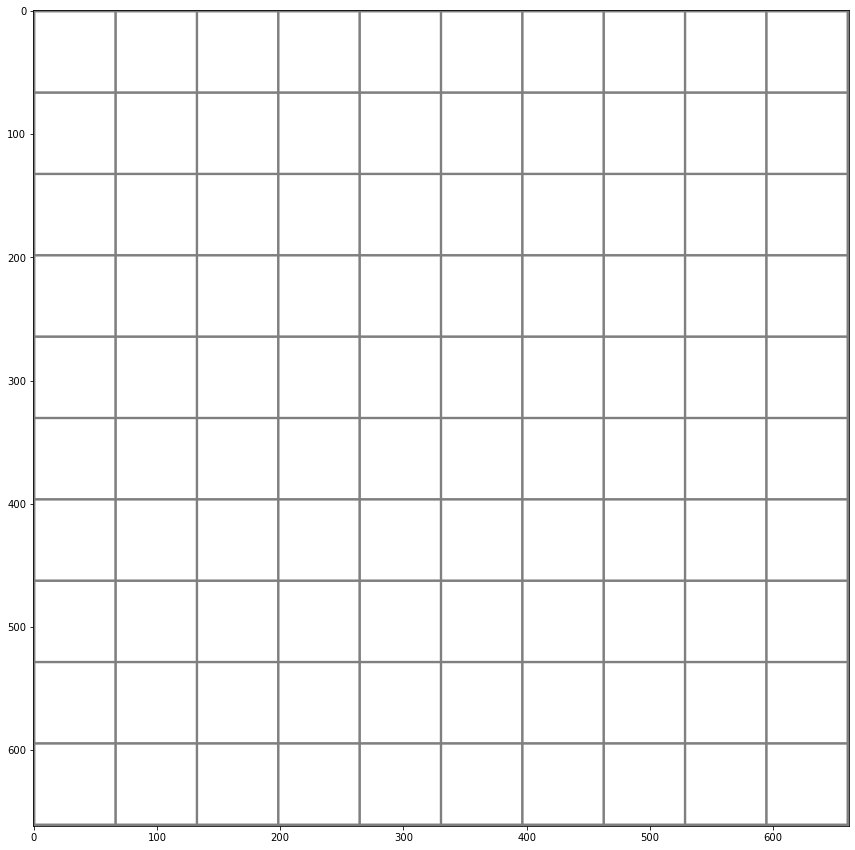

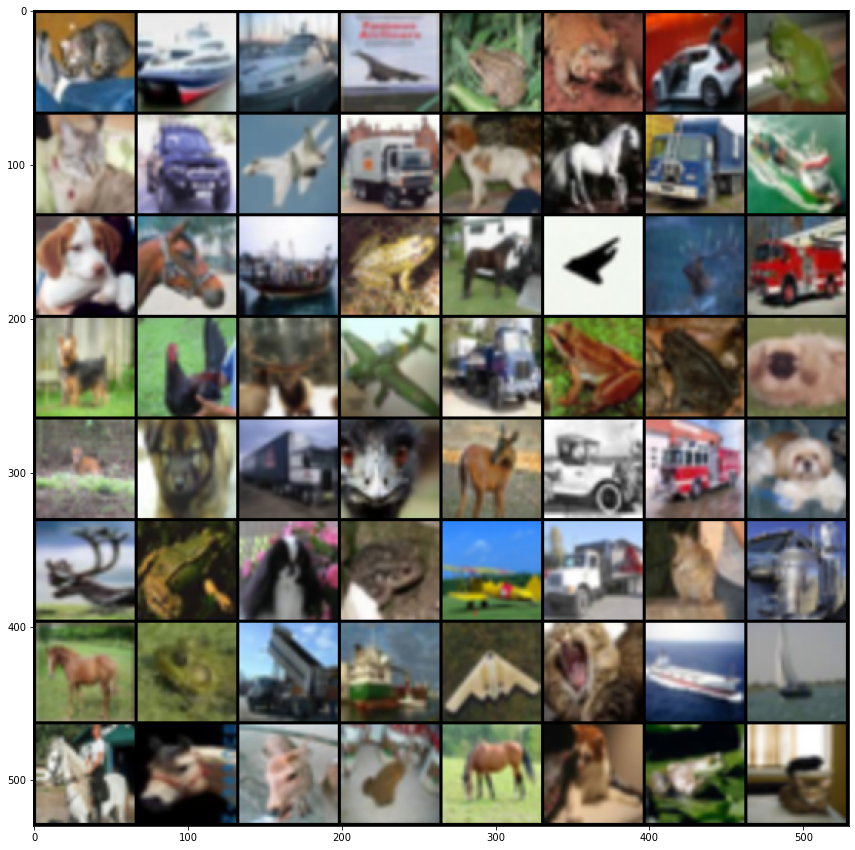

In [ ]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
#     CHANGE BACK
    save_image(generated,'./Teaching30final.png')
#     save_image(generated,'/content/drive/MyDrive/icl_dl_cw2/CW_GAN/Teaching30final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**

## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

In [ ]:
train_losses_G

[tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)]

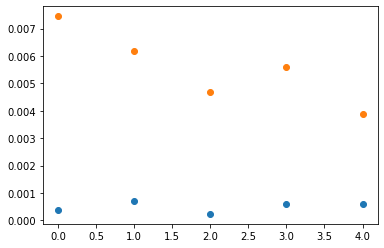

In [ ]:
# ANSWER FOR PART 2.2 IN THIS CELL*
plt.scatter(range(len(train_losses_D)),train_losses_D)
plt.scatter(range(len(train_losses_G)), train_losses_G)

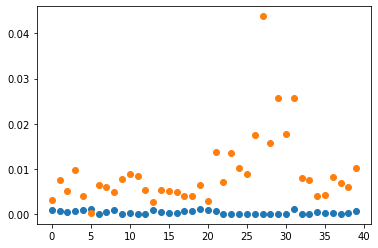

In [ ]:
# ANSWER FOR PART 2.2 IN THIS CELL*
plt.scatter(range(len(train_losses_D)),train_losses_D)
plt.scatter(range(len(train_losses_G)), train_losses_G)

### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

## Part 2.3: Understanding Mode Collapse (5 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, what this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

In [ ]:
# Any additional code

### Discussion


**YOUR ANSWER**



# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably. 

<font color="blue"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [ ]:
# If you want to run these tests yourself, change directory:
# !cd /content/drive/MyDrive/icl_dl_cw2/

In [ ]:
!pip install -q torch torchvision

In [1]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt 

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [5]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

def gan_denorm(x):
    return x

gan_latent_size = 

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [10]:
# Load VAE Dataset
test_dat = datasets.MNIST("./data/", train=False, transform=vae_transform, 
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [7]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

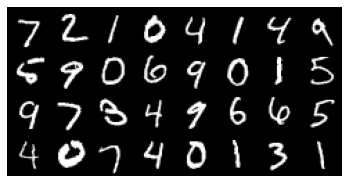

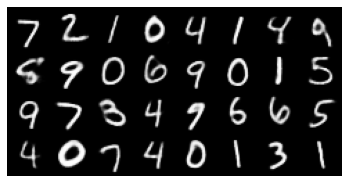

In [11]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional

for module in vae.children():
    for layer in module.children():
        if "Conv2d" in layer.original_name:
            print("Used Convs")
            break

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

In [ ]:
# GAN Tests
model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]  

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:100].detach(), nrow=10, padding=2, normalize=False, 
                    range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)